# Бонусное домашнее задание

## Part 0

В данном домашнем задании вам предстоит реализовать СLIP -- self-supervision модель которая выучивает зависимости между картинками и текстов в едином векторном пространстве. Для выполнения этого домашнего задания вам понадобится GPU и несколько дополнительных библиотек. Автор рекомендует делать все исключительно в Kaggle. 


[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)

Задания в ноутбуке будут во многом опираться на статью, поэтому рекомендуется ее прочитать перед выполнением.

In [1]:
!pip install timm
!pip install transformers

In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm
PATH_TO_IMAGES = '/kaggle/input/small-flicker-data-for-image-captioning/flickr1k/'

## Part 1 (8 баллов)

Для начала нам нужно реализовать составляющие модели: Кодировщик картинок, текста и проектор на какое-то маломерное пространство. В папке с заданием есть соответствующие файлы, заполните пропуски в них опираясь на docstring-и.

Разбалловка следующая: 

Правильно реализованные кодировщики: 2 балла.

Правильно реализованный проектор: 2 балла.

Правильно реализованный класс СLIP: 4 балла.

In [3]:
# from .CLIPDataset import CLIPDataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
# from .ImageEncoder import ImageEncoder
# from .ProjectionHead import ProjectionHead
# from .TextEncoder import TextEncoder

В одном файле все решил сделать (так и не понял как в кагле работать в несколько файлов)

In [15]:
import torch.nn as nn

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()

        """
        Here you should write simple 2-layer MLP consisting:
        2 Linear layers, GELU activation, Dropout and LayerNorm. 
        Do not forget to send a skip-connection right after projection and before LayerNorm.
        The whole structure should be in the following order:
        [Linear, GELU, Linear, Dropout, Skip, LayerNorm]
        """
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim),
            nn.Dropout(p=dropout)
        )
        self.skip = nn.Linear(embedding_dim, projection_dim)
        self.norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        """
        Perform forward pass, do not forget about skip-connections.
        """
        return self.norm(self.projection(x) + self.skip(x))


In [5]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=False):
        super().__init__()
        """
        Create the model and set its weights frozen. 
        Use Transformers library docs to find out how to do this.
        """
        # use the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

        if pretrained:
            self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        else:
            configuration = DistilBertConfig()
            self.model = DistilBertModel(configuration)

        if not trainable:
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Pass the arguments through the model and make sure to return CLS token embedding
        """
        result = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return result.last_hidden_state[:, self.target_token_idx]

In [14]:
import torch.nn as nn
import timm 


class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector.
    """
    def __init__(
        self, model_name="resnet50", pretrained=True, trainable=False):
        """
        We will use standard pretrained ResNet50, and set freeze its parameters.
        Look the documentation of TIMM on how to donwload the model: https://timm.fast.ai/
        """
        super().__init__()
        self.model = timm.create_model(model_name, pretrained, num_classes=0)
        if not trainable:
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)


In [7]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
to_tensor = T.ToTensor()
import typing as tp

class CLIPDataset(Dataset):
    def __init__(self, image_path, image_filenames, captions, tokenizer):
        """
        :image_path -- path to images
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        :tokenizer -- LM Tokenizer 
        """
        self.max_tokenizer_length = 200
        self.truncation = True
        self.padding = True
        self.image_path = image_path
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.tokenizer = tokenizer
        self.encoded_captions = self.tokenizer(self.captions, truncation=self.truncation, max_length=self.max_tokenizer_length, padding=self.padding)
        self.transforms = T.Resize([224, 244], antialias=True) # This should do.

    def __getitem__(self, idx: int) -> tp.Dict[str, tp.Union[torch.Tensor, str]]:

        """
        This one should return dict(keys=['image', 'caption'], value=[Image, Caption])
        """
        item = {
            key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()
        }
        item['image'] = self.transforms(to_tensor(Image.open(os.path.join(self.image_path, 'images/', self.image_filenames[idx])).convert('RGB')))
        item['caption'] = self.captions[idx]
        return item

    def __len__(self):
        return len(self.captions)

In [21]:
class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, temp =1.0):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projections = ProjectionHead(image_embedding)
        self.text_projections = ProjectionHead(text_embedding)
        self.temp = temp
    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        
        """
        img_enc = self.image_encoder(batch['image'])
        text_enc = self.text_encoder(batch['input_ids'], batch['attention_mask'])
        
        img_proj = self.image_projections(img_enc)
        text_proj = self.text_projections(text_enc)
        
        img_norm = nn.functional.normalize(img_proj)
        text_norm = nn.functional.normalize(text_proj)
        
        logits = (img_norm @ text_norm.T) / self.temp
        
        targets = F.softmax(((img_norm @ img_norm.T) + (text_norm @ text_norm.T)) / (2 * self.temp), dim=-1)
        
        loss_i = CE(logits, targets)
        loss_t = CE(logits.T, targets.T)
        loss = (loss_i + loss_t) / 2
        
        return torch.mean(loss)
        
    

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

# Part 2. (0 Баллов)

Здесь вам нужно вписать правильный путь до csv файла на своей машине и запустить код.

In [9]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{PATH_TO_IMAGES}captions.csv")
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [10]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        PATH_TO_IMAGES,
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [11]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [12]:
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

## Part 3. (2 балла)

За вас написан минимальный код для обучения, если он запускается и модель учится, то за этот пункт вы получите 0.5 балла. Чтобы получить полный балл за задание вам нужно будет провести несколько экспериментов и поподбирать гиперпараметры. Можно начать со статьи.

In [13]:
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
def procedure(t=1):
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP(temp=t).to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [22]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 3.466
Validation loss: CrossEntropyLoss: 3.455
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.466
Validation loss: CrossEntropyLoss: 3.455
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 3.463
Validation loss: CrossEntropyLoss: 3.455
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 3.461
Validation loss: CrossEntropyLoss: 3.455
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 3.461
Validation loss: CrossEntropyLoss: 3.455
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 3.461
Validation loss: CrossEntropyLoss: 3.455
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 3.414
Validation loss: CrossEntropyLoss: 3.315
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 3.339
Validation loss: CrossEntropyLoss: 3.300
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 3.318
Validation loss: CrossEntropyLoss: 3.284
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 3.308
Validation loss: CrossEntropyLoss: 3.281


## Part 4 (0 баллов)

Просто посмотрим на результаты.

In [23]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
#         image_features = model.image_encoder(batch["image"].permute(0, 3, 1, 2)).to(device)
        image_features = model.image_encoder(batch["image"]).to(device)
        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [24]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGES}" 'images/' + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()

In [25]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

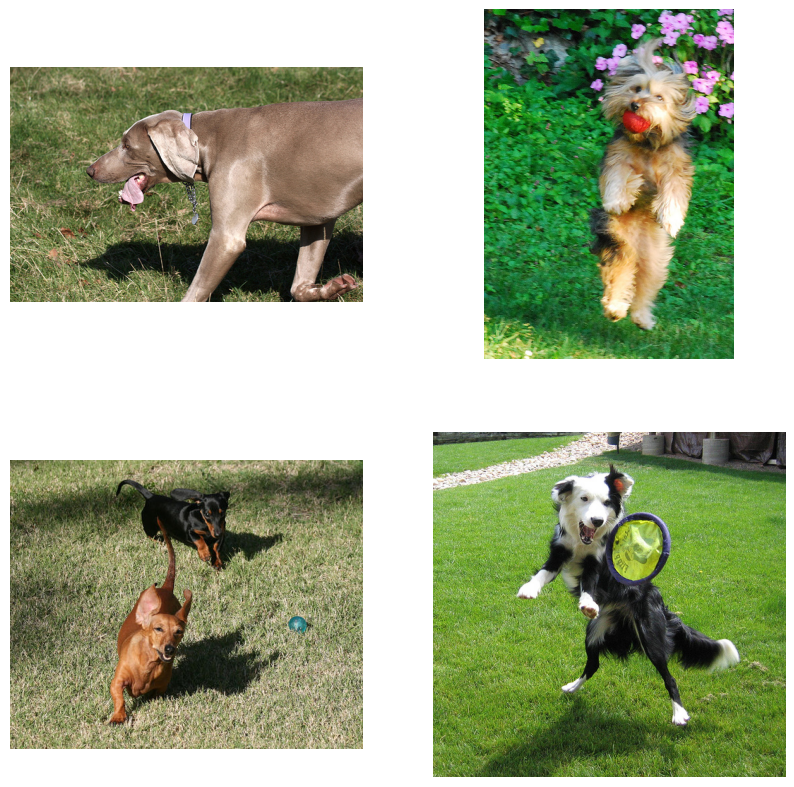

In [26]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

## Опишите свои результаты.

Все везде собаки) Все отлично, все замечательно!